# Project Contents
## 1. Data Ingestion & Preprocessing
- 1.1 Get Chipotle's business data on Yelp
- 1.2 Get Chipotle's reviews data on Yelp
- 1.3 Merge Chipotle's business data and review data
## 2. Getting Reviews' Sentiment
- 2.1 Calculate reviews' sentiment score using TextBlob
- 2.2 Classifying each review's sentiment based on its sentiment score
- 2.3 Visualize the sentiment breakdown of all reviews
- 2.4 Plot the review sentiment distribution across star rating groups
## 3. Text Processing
- 3.1 Stopwords Removal
- 3.2 Handle negation
- 3.3 Remove non-word and punctuations
- 3.4 Convert to lower case
## 4. Get the top 10 frequent words and their occurrence ratio in positive/negative reviews
- 4.1 Select the top 10 frequent words (woi: word of interest) in the reviews and count their occurrences
- 4.2 Calculate Word Occurence Ratio in Positive / Negative Reviews
## 5. Time Series Analysis
- 5.1 Plot the monthly average star rating of Chipotle
- 5.2 Plot the number of reviews in different star rating groups over time
- 5.3 Plot the monthly total positive / negative reviews
- 5.4 Plot the top 10 frequent words' occurrence ratios in both positive reviews and negative reviews

In [23]:
import json
import pandas as pd
import numpy as np

import re
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import collections

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Ingestion & Preprocessing

### 1.1 Get Chipotle's business data on Yelp

In [2]:
business_json_path = 'business.json'
df_business = pd.read_json(business_json_path, lines=True)
# drop irrelevant columns
df_business.drop(labels = {'address', 'postal_code', 'latitude', 'longitude', 'attributes', 'hours'}, axis = 1, inplace = True)

In [3]:
df_business.head(2)

,business_id,name,city,state,stars,review_count,is_open,categories
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,Phoenix,AZ,3.0,5,0,"Golf, Active Life"
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,1,"Specialty Food, Restaurants, Dim Sum, Imported..."


In [4]:
# boi stands for business of interest: Chipotle
boi_list = ['Chipotle Mexican Grill']
df_business = df_business.loc[df_business['name'].isin(boi_list)]
df_business.head(2)

,business_id,name,city,state,stars,review_count,is_open,categories
542,dusNIzdCaH6EoLl2hRy6cQ,Chipotle Mexican Grill,Las Vegas,NV,3.5,115,1,"Fast Food, Mexican, Restaurants"
1703,_EVOLAjWYEfSOO_smbBxaA,Chipotle Mexican Grill,Wexford,PA,2.5,19,1,"Restaurants, Mexican, Fast Food"


### 1.2 Get Chipotle's reviews data on Yelp

In [5]:
review_json_path = 'review.json'
df_review = pd.read_json(review_json_path, lines=True)

In [6]:
# drop review_id and user_id columns
drop_columns = ['review_id','user_id']
df_review.drop(drop_columns, axis=1, inplace=True)

In [7]:
df_review.head(2)

,business_id,stars,useful,funny,cool,text,date
0,ujmEBvifdJM6h6RLv4wQIg,1,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,NZnhc2sEQy3RmzKTZnqtwQ,5,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33


### 1.3 Merge business data and review data of Chipotle

In [8]:
# map of all business ids of boi's (in this case only Chipotle)
bid_map = {}

for boi in boi_list:
    bid_map[boi] = df_business.loc[df_business['name'] == boi]['business_id'].tolist()
    print("{}: {}".format(boi, bid_map[boi][:5]))

Chipotle Mexican Grill: ['dusNIzdCaH6EoLl2hRy6cQ', '_EVOLAjWYEfSOO_smbBxaA', '0rN_o7_IfshAHQwzMUK8nA', '8Rydf8hXleCwbCN9nvmZ4Q', 'VFv7NcPW9ajUTLleJ8wOQA']


In [9]:
boi_review_df_list = []
for restuarant in boi_list:
    boi_review_df_list.append(df_review.loc[df_review['business_id'].isin(bid_map[restuarant])].drop('business_id', axis=1))

In [10]:
for i, boi_name in enumerate(boi_list):
    print("\n\n{}: totally {} reviews.".format(boi_name, boi_review_df_list[i].shape[0]))
    print(boi_review_df_list[i].head())



Chipotle Mexican Grill: totally 9590 reviews.
      stars  useful  funny  cool  \
275       1       1      0     0   
598       5       0      0     0   
969       2       0      0     0   
1093      3       0      0     0   
1592      4       1      0     0   

                                                   text                date  
275   I'm a regular at chipotle in California, this ... 2016-07-25 05:07:18  
598   I've been here 10+ times now and each time the... 2014-12-17 17:37:38  
969   Not the chipotle it used to be compared to cou... 2013-11-14 04:23:42  
1093  Honestly, you can't go wrong. The quality is c... 2015-03-04 20:05:34  
1592  I come here when I'm in the mood for some fast... 2016-01-04 05:09:53  


In [11]:
boi_name_df_list = [ pd.DataFrame(data={
  'business_name': [boi_name]
}) for boi_name in boi_list ]

In [12]:
for i, df in enumerate(boi_review_df_list):
    boi_review_df_list[i] = df.assign(**boi_name_df_list[i].iloc[0])
    print(boi_review_df_list[i].head())

stars  useful  funny  cool  \
275       1       1      0     0   
598       5       0      0     0   
969       2       0      0     0   
1093      3       0      0     0   
1592      4       1      0     0   

                                                   text                date  \
275   I'm a regular at chipotle in California, this ... 2016-07-25 05:07:18   
598   I've been here 10+ times now and each time the... 2014-12-17 17:37:38   
969   Not the chipotle it used to be compared to cou... 2013-11-14 04:23:42   
1093  Honestly, you can't go wrong. The quality is c... 2015-03-04 20:05:34   
1592  I come here when I'm in the mood for some fast... 2016-01-04 05:09:53   

               business_name  
275   Chipotle Mexican Grill  
598   Chipotle Mexican Grill  
969   Chipotle Mexican Grill  
1093  Chipotle Mexican Grill  
1592  Chipotle Mexican Grill  


In [13]:
df = pd.concat(boi_review_df_list, axis=0)
df.head()

,stars,useful,funny,cool,text,date,business_name
275,1,1,0,0,"I'm a regular at chipotle in California, this ...",2016-07-25 05:07:18,Chipotle Mexican Grill
598,5,0,0,0,I've been here 10+ times now and each time the...,2014-12-17 17:37:38,Chipotle Mexican Grill
969,2,0,0,0,Not the chipotle it used to be compared to cou...,2013-11-14 04:23:42,Chipotle Mexican Grill
1093,3,0,0,0,"Honestly, you can't go wrong. The quality is c...",2015-03-04 20:05:34,Chipotle Mexican Grill
1592,4,1,0,0,I come here when I'm in the mood for some fast...,2016-01-04 05:09:53,Chipotle Mexican Grill


## 2. Data Processing - Getting Reviews' Sentiment

### 2.1 Calculate sentiment score of each review using TextBlob

In [14]:
# function for calculating the sentiment score of each review
def sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

In [15]:
df['sentiment_socre'] = df['text'].apply(sentiment)
df.head(2)

,stars,useful,funny,cool,text,date,business_name,sentiment_socre
275,1,1,0,0,"I'm a regular at chipotle in California, this ...",2016-07-25 05:07:18,Chipotle Mexican Grill,-0.080043
598,5,0,0,0,I've been here 10+ times now and each time the...,2014-12-17 17:37:38,Chipotle Mexican Grill,0.258965


### 2.2 Classifying each review's sentiment based on the sentiment score

In [16]:
df['sentiment'] = ''
df['sentiment'][df['sentiment_socre'] > 0] = 'positive'
df['sentiment'][df['sentiment_socre'] < 0] = 'negative'
df['sentiment'][df['sentiment_socre'] == 0] = 'neutral'
df.head(2)

/home/ruic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ruic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ruic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after r

,stars,useful,funny,cool,text,date,business_name,sentiment_socre,sentiment
275,1,1,0,0,"I'm a regular at chipotle in California, this ...",2016-07-25 05:07:18,Chipotle Mexican Grill,-0.080043,negative
598,5,0,0,0,I've been here 10+ times now and each time the...,2014-12-17 17:37:38,Chipotle Mexican Grill,0.258965,positive


### 2.3 Visualize the sentiment breakdown of all reviews of Chipotle

Text(0.5, 1.0, 'Review Sentiments')

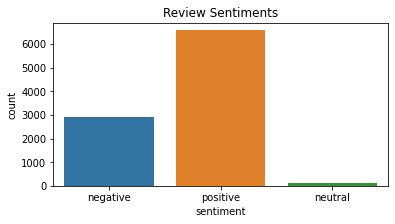

In [17]:
plt.figure(figsize=(6,3))
ax = sns.countplot(df['sentiment'])
plt.title('Review Sentiments')

### 2.4 Plot the review sentiment distribution across star rating groups

Text(0.5, 1.0, 'Review Sentiment Distrubition across Star Rating Groups')

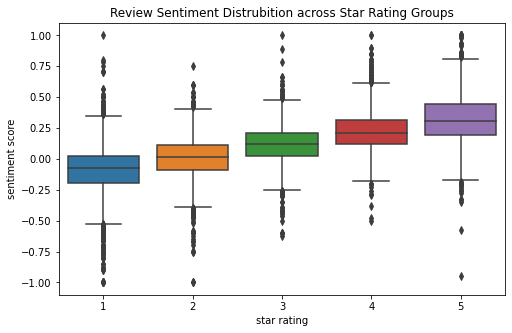

In [46]:
plt.figure(figsize=(8,5))
fig = sns.boxplot(x ='stars',y='sentiment_socre',data = df)
fig.set(xlabel='star rating', ylabel='sentiment score')
plt.title('Review Sentiment Distrubition across Star Rating Groups')

## 3. Data Processing - Text processing

### 3.1 Remove stop words but preserve "not"

In [24]:
# remove stop words but preserve not
stop_words = stopwords.words('english')
# exclude not from stopwords
criteria_not = re.compile(r'not')
criteria_nt = re.compile(r"[a-z]+n't")
stop_words = [stop_word for stop_word in stop_words if not criteria_not.match(stop_word) and not criteria_nt.match(stop_word)]
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

### 3.2 Handle negation

In [25]:
sub_nt = re.compile(r"n't")
handle_not = re.compile(r"not (?=[a-zA-Z]+)")
df['text'] = df['text'].apply(lambda x: sub_nt.sub(r' not', x))
df['text'] = df['text'].apply(lambda x: handle_not.sub(r'not_', x))

### 3.3 Remove non-word and punctuations

In [26]:
rm_punc = re.compile(r"\W")
shrink_spaces = re.compile(r"\s+")
df['text'] = df['text'].apply(lambda x: rm_punc.sub(' ', x))
df['text'] = df['text'].apply(lambda x: shrink_spaces.sub(' ', x))

### 3.4 Convert to lower case

In [31]:
df['text'] = df['text'].apply(lambda x: x.lower())

## Create a Word Cloud for Chipotle's reviews

In [34]:
# Create a list of words in all reviews
text = " ".join(review for review in df.text)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 3276933 words in the combination of all review.


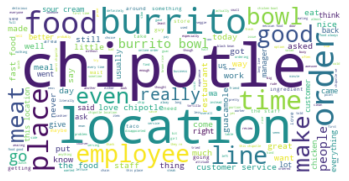

In [35]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["one", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 4. Get the top 10 frequent words and their occurrence ratio in both positive reviews and negative reviews

### 4.1 Select the top 10 frequent words in the reviews and count their occurrences

In [48]:
review_list = df['text'].tolist()
review_joined = ' '.join(review_list)
word_list = [word for word in review_joined.lower().split() if word not in STOPWORDS]
counted_words = collections.Counter(word_list)
words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
counted_words

r': 1,
         'white': 366,
         'really': 1601,
         'notice': 88,
         'bit': 599,
         'charred': 24,
         'dry': 156,
         'sometimes': 417,
         'normally': 184,
         'not_problem': 30,
         'fajita': 257,
         'veggies': 375,
         'hit': 167,
         'miss': 126,
         'sautéed': 10,
         'crunchy': 72,
         'raw': 86,
         'taste': 477,
         'corn': 529,
         'salsa': 1148,
         'tell': 379,
         'person': 541,
         'stuff': 233,
         'tend': 65,
         'give': 1015,
         'smaller': 170,
         'portion': 456,
         'locations': 619,
         'slowest': 96,
         'ordering': 511,
         'process': 96,
         'always': 3373,
         'screwed': 30,
         'ready': 396,
         'supposed': 112,
         'missing': 123,
         'items': 232,
         'country': 47,
         'opinion': 78,
         '4': 569,
         'stars': 532,
         'came': 712,
         'weeks': 89,
  

### 4.2 Calculate Word Occurence Ratio in Positive / Negative Reviews

In [49]:
# count each word's occurrence in positive reviews as pcount and occurrence in negative reviews as ncount
pcount = []
ncount = []
for word in words:
    pcount.append(sum(df[df['sentiment'] == "positive"]["text"].str.contains(word)))
    ncount.append(sum(df[df['sentiment'] == "negative"]["text"].str.contains(word)))

# normalize pcount with the total number of positive reviews and ncount with the total number of negtive reviews
pcount_normalized = np.asarray(pcount)/df.loc[df['sentiment'] == "positive"].shape[0]
ncount_normalized = np.asarray(ncount)/df.loc[df['sentiment'] == "negative"].shape[0]

# create a df to store the words' positive occurrence ratio and negative occurrence ratio
word_pos_neg_cnt_df = pd.DataFrame({'positive ratio': pcount_normalized, 'negative ratio': ncount_normalized}, index=words)
word_pos_neg_cnt_df.head()

,positive ratio,negative ratio
chipotle,0.602800,0.589310
food,0.540709,0.444138
location,0.369959,0.378621
burrito,0.312433,0.260000
one,0.422615,0.454483


## 5. Time Series Analysis

### 5.1 Plot the monthly average star rating of Chipotle

In [50]:
# Get the monthly average star rating of Chipotle
df_star = df[['stars', 'date']]
star_monthly_change = df_star.set_index('date').resample('M').stars.mean()
star_monthly_change = star_monthly_change.dropna()
star_monthly_change.head()

date
2005-11-30    3.0
2005-12-31    4.0
2006-01-31    5.0
2006-05-31    3.0
2006-06-30    5.0
Name: stars, dtype: float64

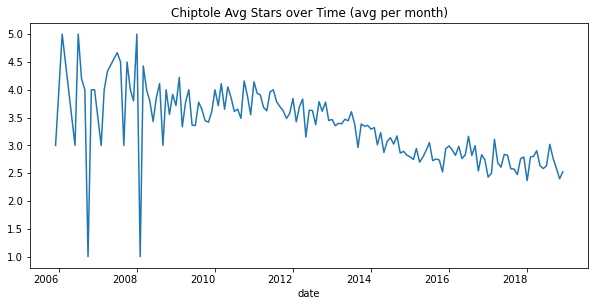

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
star_monthly_change.plot.line(label='Stars', ax=ax, rot=0, figsize=(10, 5), title="Chiptole Avg Stars over Time (avg per month)")

### 5.2 Plot the number of reviews in different star rating groups over time


Text(0.5, 1.0, 'Number of Reviews in Different Rating Groups over Time')

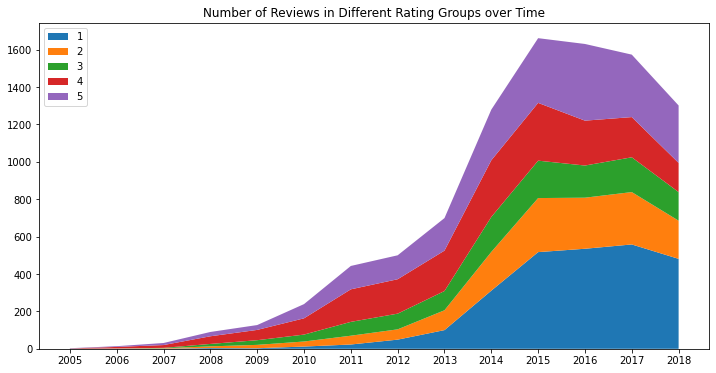

In [55]:
df['year'] = df['date'].dt.to_period('Y')
pivot = pd.pivot_table(df, index=['stars'],
                         columns=['year'],
                         values=['text'], 
                         aggfunc = lambda x: len(x), 
                         fill_value=0)

year_list = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
fig= plt.figure(figsize = (12,6))
plt.stackplot(year_list, pivot.values, labels = pivot.index)
ax = plt.gca()
ax.set_xticks(year_list)
plt.legend(loc='upper left')
plt.title('Number of Reviews in Different Rating Groups over Time')

### 5.3 Plot the total positive / negative reviews per month

In [52]:
# calculate the monthly total positive reviews and the monthly total negative reviews
df_monthly_pos_cnt = df.set_index('date').groupby('sentiment').get_group('positive').resample('M').count().sentiment
df_monthly_neg_cnt = df.set_index('date').groupby('sentiment').get_group('negative').resample('M').count().sentiment
print(df_monthly_pos_cnt.head())
print()
print(df_monthly_neg_cnt.head())

date
2005-11-30    2
2005-12-31    1
2006-01-31    1
2006-02-28    0
2006-03-31    0
Freq: M, Name: sentiment, dtype: int64

date
2006-05-31    1
2006-06-30    0
2006-07-31    0
2006-08-31    0
2006-09-30    0
Freq: M, Name: sentiment, dtype: int64


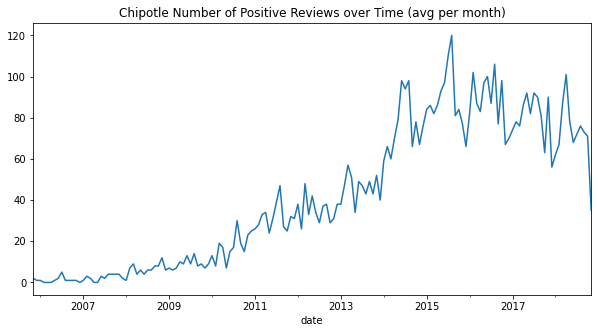

In [53]:
# plot the monthly total positive reviews
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df_monthly_pos_cnt.plot.line(label='Number of Positive Reviews', ax=ax, rot=0, figsize=(10, 5), title="Chipotle Number of Positive Reviews over Time (avg per month)", style='-')

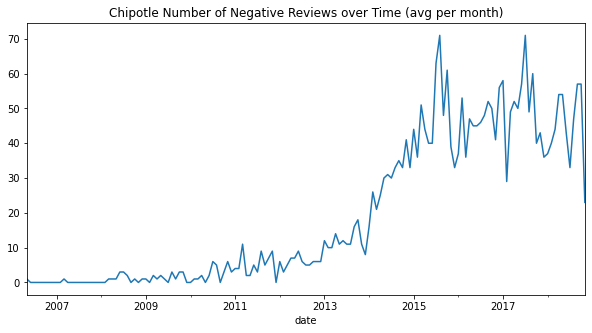

In [54]:
# plot the monthly total negative reviews
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
df_monthly_neg_cnt.plot.line(label='Number of Negative Reviews', ax=ax, rot=0, figsize=(10, 5), title="Chipotle Number of Negative Reviews over Time (avg per month)", style='-')

### 5.4 Plot the top 10 frequent words' occurrence ratios in both positive reviews and negative reviews

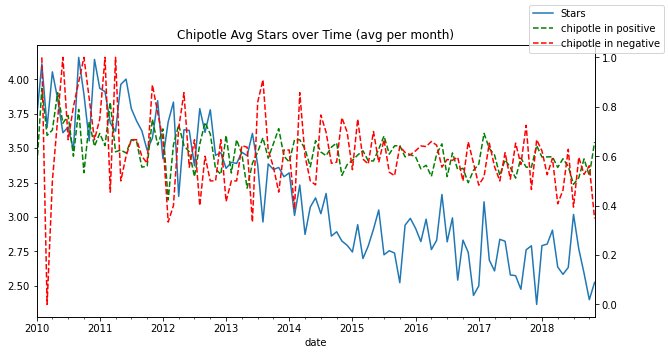

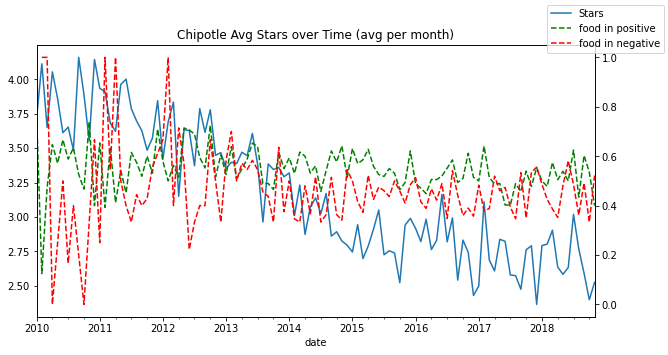

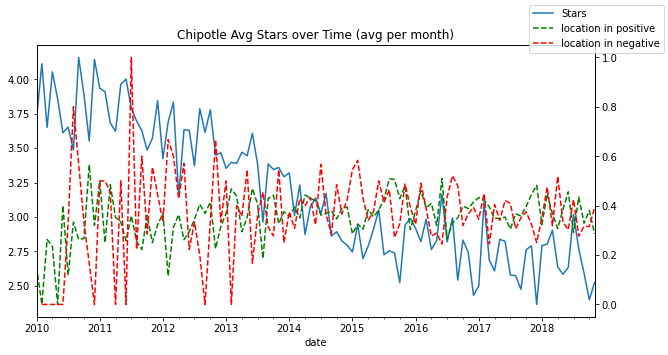

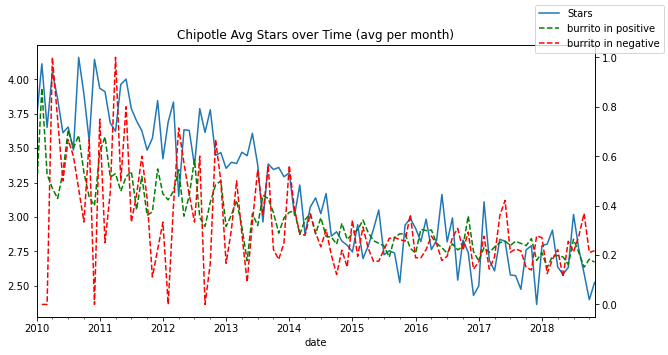

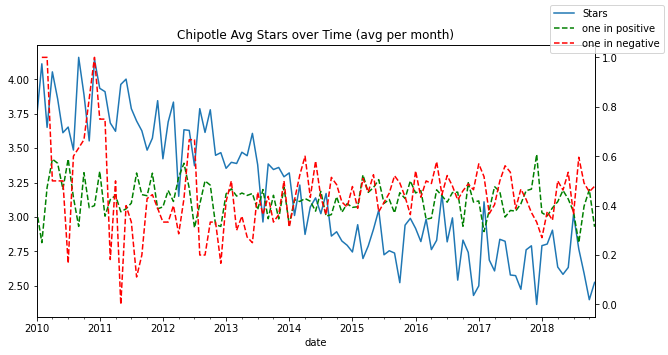

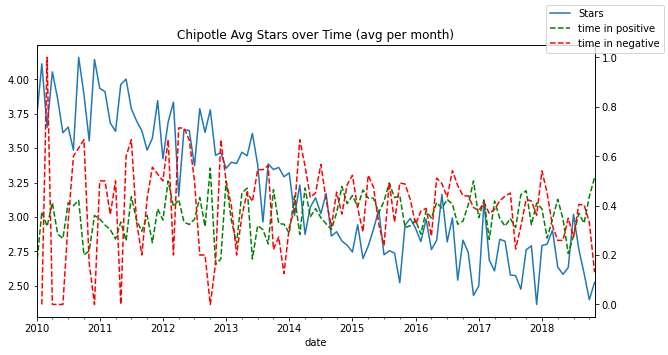

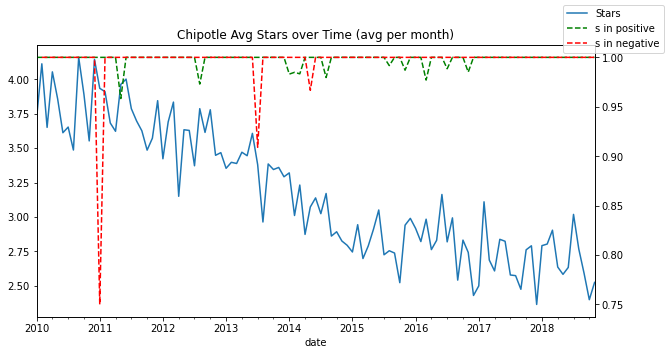

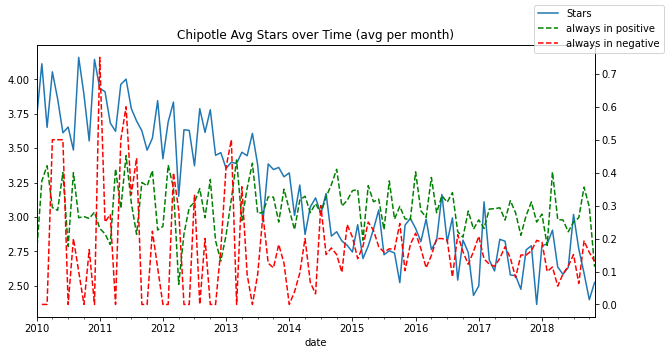

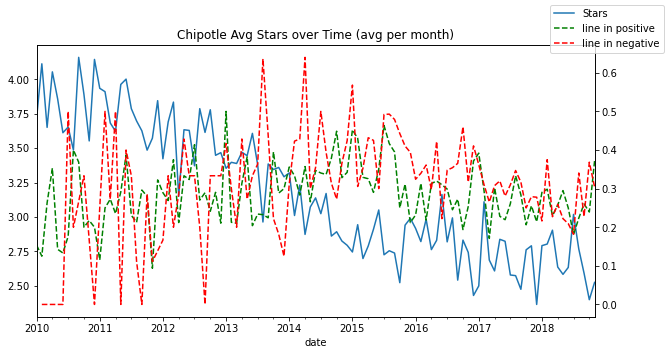

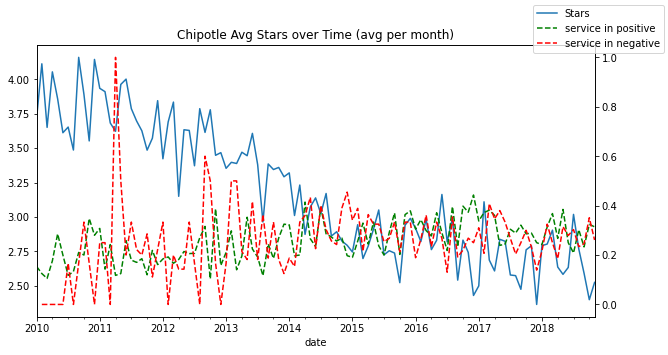

In [57]:
def GetStarsInDateRange(x, start, end, colname):
    x_df = x.to_frame().reset_index('date')
    return x_df.loc[(x_df['date'] >= start) & (x_df['date'] <= end)].set_index('date')[colname]

start_date = '2010-01-01'
end_date = '2018-12-31'

for woi in words:
    df_woi = df.loc[df['text'].str.contains(woi)]
    df_woi.head()
    df_woi_pos_cnt = df_woi.set_index('date').groupby('sentiment').get_group('positive').resample('M').count().sentiment
    df_woi_neg_cnt = df_woi.set_index('date').groupby('sentiment').get_group('negative').resample('M').count().sentiment

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    stars_plot = GetStarsInDateRange(star_monthly_change, start_date, end_date, 'stars')
    stars_plot.plot.line(label='Stars', ax=ax, rot=0, figsize=(10, 5), title="Chipotle Avg Stars over Time (avg per month)", style='-')
    ax_r = ax.twinx()

    df_woi_pos_ratio = df_woi_pos_cnt.divide(df_monthly_pos_cnt, fill_value=0.0)
    df_woi_pos_ratio = df_woi_pos_ratio.dropna()
    woi_pos_ratio_plot = GetStarsInDateRange(df_woi_pos_ratio, start_date, end_date, 'sentiment')
    woi_pos_ratio_plot.plot.line(label='{} in positive'.format(woi), ax=ax_r, rot=0, style='g--')

    df_woi_neg_ratio = df_woi_neg_cnt.divide(df_monthly_neg_cnt, fill_value=0.0)
    df_woi_neg_ratio = df_woi_neg_ratio.dropna()
    woi_neg_ratio_plot = GetStarsInDateRange(df_woi_neg_ratio, start_date, end_date, 'sentiment')
    woi_neg_ratio_plot.plot.line(label='{} in negative'.format(woi), ax=ax_r, rot=0, style='r--')

    fig.legend()